<a href="https://colab.research.google.com/github/jnirschl/detecting-mitigating-bias-base/blob/main/notebooks/Milestone_3_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 3 
 
#### Objective:

 - Build a model with algorithmic gender bias. Using SHAP, AIF-360, and manual calculations, detect algorithmic bias. Then, using AIF-360, mitigate the bias you detected.

#### Workflow:

1. Import modules, register helper functions, and load data
2. Train a model without unwanted gender bias. Demonstrate using confusion matrices and bias metrics that the model has minimal allocation bias. 
3. Train a model with gender bias.  Demonstrate using confusion matrices that the model is significantly biased. 
4. Use SHAP to interpret the biased model's predictions and demonstrate bias.
5. Debias the model using AIF-360. Between three debiasing approaches (reweighing, disparate impact remover, and calibrated equal odds postprocessing),  choose one of the approaches, recommend it for use, and explain why.

6. Fine-tune your reweighing and disparate impact remover approaches by selecting the best possible threshold.

#### Importance to Project:

 - In the scenario of this LiveProject, you are called upon to detect and/or mitigate unwanted bias in three models (and their corresponding datasets) for the WHO. Here we work with two models - one which probably does not have unwanted bias, and one which does. In these cases, the protected class data is available. For our final model, in Milestone 4, it is not available. 
 - Most of the work here is done on the model which does have unwanted bias. We want to measure that bias and try and mitigate it. The workflow guides you through that process.
 
#### Resources:
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6678298/ (a description of the original dataset and its use)
 - https://arxiv.org/pdf/1810.01943.pdf (the original AIF360 paper, which describes several methods for debiasing implemented within the package)
 - https://aif360.mybluemix.net/data (a demo of AIF360. Here, we are unpacking what is done at the "check" and "mitigate" steps.) 
 - https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb (a helpful summary of key metrics. Section 4.7 on impossibility is relevant for the final section of this milestone.)

# 1. Import modules, register helper functions, and load data



The dataset we are using is a cardiology dataset described in Padmanabhan et al.’s [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6678298/) in the _Journal of Clinical Medicine_. In the original dataset, the “cardio” column represented whether the patient has cardiovascular disease.

In our scenario, we can obtain all of the measurements in the dataset, but we cannot detect cardiovascular disease directly. This is where a model is used. A patient who has a prediction of cardiovascular disease will be given a medication that reduces the likelihood of a cardiac event, but not enough medication is available to give to everyone, so our model will also be used to prioritize the allocation of that medicine.

To introduce you to the data, let’s do the following:

1. Import the relevant modules and helper functions.
2. Load the data from 'cardio_train.csv'.
3. Drop NAN values.
4. Sort the data by 'cardio', the target variable.
5. Inspect the dataframe, and familiarize yourself with the labels (see table 2 of Padmanabhan et al.’s paper).

Run the below helper code to get started. To see this code in context, click [here](https://colab.research.google.com/drive/1pLOgIU_t998KKEcO9nz_6T8xWr05R1UT#scrollTo=ft07GaGRn--H&line=1&uniqifier=1)

In [1]:
!pip install scikit-learn aif360 pandas lightgbm shap BlackBoxAuditing seaborn matplotlib

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    
import numpy as np
import shap
import sklearn
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import aif360
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics import ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.explainers import MetricTextExplainer

In [3]:
def generate_biased_dataset(dataset, women_yes_event_subsample_rate):
    
    """ (DataFrame, float) -> DataFrame
    Using the Cardio dataset, subsample positive cardiac events for women"""
    
    women_no_event = dataset[(dataset['gender']==1) & (dataset['cardio']==0)]
    women_yes_event = dataset[(dataset['gender']==1) & (dataset['cardio']==1)]
    men_no_event = dataset[(dataset['gender']==2) & (dataset['cardio']==0)]
    men_yes_event = dataset[(dataset['gender']==2) & (dataset['cardio']==1)]

    biased_dataset = pd.concat([
        women_no_event,
        women_yes_event.sample(int(len(women_yes_event)*women_yes_event_subsample_rate)),
        men_no_event,
        men_yes_event
    ])
    return biased_dataset

def train_model(dataset, exclude_gender = False):
    
    """ (DataFrame, bool) -> RandomForestClassifier, DataFrame, DataFrame, DataFrame, DataFrame
    Given a dataset in Cardio format, split the model into train and test, and train a Random Forest classifier on the data"""
    
    X_cols = [c for c in dataset.columns if c!='cardio']
    X = dataset[X_cols]
    y = dataset['cardio']
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    if exclude_gender:
        X_cols.remove('gender')
    rf.fit(X_train[X_cols], y_train)
        
    return rf, X_cols, X_train, X_test, y_train, y_test

 

def plot_confusion_matrix(y_true,y_pred, return_percentage=False):
    
    """ (Series, Series, bool) -> None
    Plot a confusion matrix"""
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    
    if return_percentage:
        cm = np.round(np.asarray(cm)/(np.asarray(cm).sum()),3)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens',fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);
    plt.show()
    return cm
    
def aif360_to_pandas(dataset_aif360):
    return dataset_aif360.convert_to_dataframe()[0]

def pandas_to_aif360(dataset_pd):
    return aif360.datasets.BinaryLabelDataset(favorable_label=1,
                                              unfavorable_label=0,
                                              df=dataset_pd,
                                              label_names=['cardio'],
                                              protected_attribute_names=['gender',
                                                                         'dummy'])
    

In [4]:
# read data from url
import requests
data_url = "https://raw.githubusercontent.com/mikejump/detecting-mitigating-bias-base/main/data/cardio_train.csv"

dataset = pd.read_csv(data_url, delimiter=';')

# add dummy random variable for negative control testing fairness metrics
# the random dummy var should have no bias and negligible Shap contribution
dataset['dummy'] = np.random.choice(2, size=dataset.shape[0])


# drop nans
dataset = dataset.dropna()

dataset.sort_values('cardio',ascending=False)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,dummy
23316,33309,19645,1,160,80.0,130,80,3,1,0,0,1,1,0
28870,41257,15868,1,158,83.0,160,100,1,1,0,0,1,1,0
55488,79158,21224,2,178,95.0,150,90,1,1,0,0,1,1,1
55486,79156,18111,1,164,90.0,140,1000,3,1,0,0,1,1,1
28862,41249,19688,1,160,63.0,110,80,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30978,44245,20991,1,164,85.0,120,80,2,1,0,0,1,0,0
30979,44246,16950,1,162,54.0,110,80,1,1,0,0,1,0,1
30980,44248,19036,1,165,89.0,130,80,1,1,0,0,1,0,0
30982,44250,15954,1,165,72.0,120,70,1,3,0,0,1,0,1


# 2. Train a model without unwanted gender bias. Demonstrate using confusion matrices and bias metrics that the model has minimal allocation bias. 



A model trained from this data will not be subject to significant bias. However, being able to recognize when a model isn't biased is an important part of the debiasing process.

Code is provided below to do the following steps:

1. Using the helper function train_model, train a model.
2. Using the helper function plot_confusion_matrix, plot a confusion matrix based on the model's predictions for the test set.
3. Split the patients in the test set by gender, and create a confusion matrix for each.

Based on the confusion matrices generated above, you are asked to

* Manually measure the disparate impact by dividing the ratio of positive predictions for females by the ratio of positive predictions for males. There should be negligible bias (disparate impact is close to 1).

* Manually measure the equal opportunity difference by subtracting the true positive rate for males from the true positive rate for females. There should be negligible bias (equal opportunity difference is close to 0).

To see the below code in context, click [here](https://colab.research.google.com/drive/1pLOgIU_t998KKEcO9nz_6T8xWr05R1UT#scrollTo=DgQYKzeGn--I&line=3&uniqifier=1)

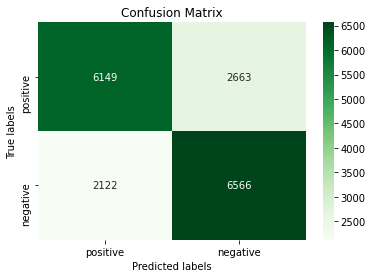

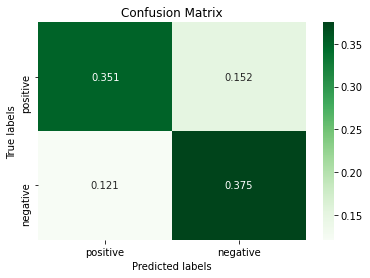

array([[0.351, 0.152],
       [0.121, 0.375]])

In [5]:
original_rf, X_cols,X_train, X_test, y_train, y_test = train_model(dataset)
plot_confusion_matrix(y_test, original_rf.predict(X_test[X_cols]))
plot_confusion_matrix(y_test, original_rf.predict(X_test[X_cols]),return_percentage=True)

confusion matrix for women in test


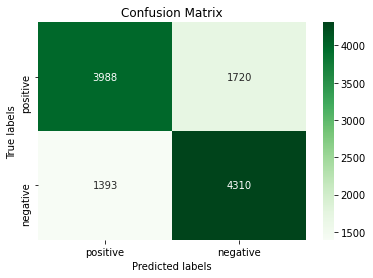

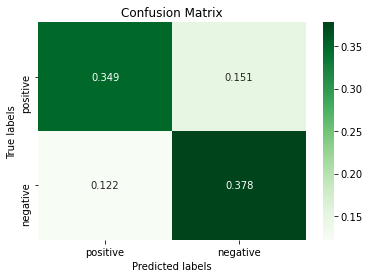

confusion matrix for men in test


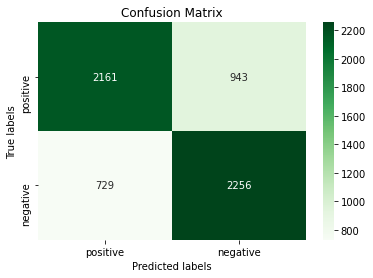

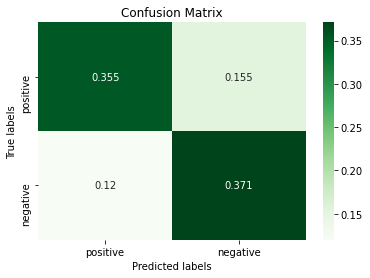

array([[0.355, 0.155],
       [0.12 , 0.371]])

In [6]:
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)
print('confusion matrix for women in test')
cm_female = plot_confusion_matrix(y_test[women_test_idx], original_rf.predict(X_test[X_cols][women_test_idx]))
plot_confusion_matrix(y_test[women_test_idx], original_rf.predict(X_test[X_cols][women_test_idx]),return_percentage=True)

print('confusion matrix for men in test')
cm_male = plot_confusion_matrix(y_test[men_test_idx], original_rf.predict(X_test[X_cols][men_test_idx]))
plot_confusion_matrix(y_test[men_test_idx], original_rf.predict(X_test[X_cols][men_test_idx]),return_percentage=True)

### Place your disparate impact and equal opportunity difference measurements here

In [7]:
# true positive rate
def calc_metric(conf_mat, metric=None):
  assert (metric.lower() in {"tpr","pos_rate","neg_rate"}), "Expected TPR or Pos_Rate"

  TP = conf_mat[0][0]
  FN = conf_mat[0][1]
  FP = conf_mat[1][0]
  TN = conf_mat[1][1]

  TPR = TP/(TP+FN)
  pos_rate, neg_rate = np.sum(conf_mat, axis=0)/np.sum(conf_mat[:])

  if metric.lower() == "tpr":
    return TPR

  if metric.lower() == "pos_rate":
    return pos_rate

  if metric.lower() == "neg_rate":
    return neg_rate

In [8]:
# compute equal opportunity difference
tpr_female = calc_metric(cm_female, metric="tpr")
tpr_male = calc_metric(cm_male, metric="tpr")
eodiff = tpr_female-tpr_male
print(f"Equal opportunity difference:\n\tRecall (female):\t{tpr_female}")
print(f"\tRecall (male):\t\t{tpr_male}")
print(f"\tEqual opp. diff.:\t{eodiff}")

# compute disparate impact
pos_rate_female = calc_metric(cm_female, metric="pos_rate")
pos_rate_male = calc_metric(cm_male, metric="pos_rate")
disp_impact = pos_rate_female/pos_rate_male
print(f"Disparate impact:\n\tRecall (female):\t{pos_rate_female}")
print(f"\tRecall (male):\t\t{pos_rate_male}")
print(f"\tEqual opp. diff.:\t{disp_impact}")

Equal opportunity difference:
	Recall (female):	0.6986685353889278
	Recall (male):		0.6961984536082474
	Equal opp. diff.:	0.002470081780680422
Disparate impact:
	Recall (female):	0.47156252738585575
	Recall (male):		0.47462637543110525
	Equal opp. diff.:	0.9935447160043168


In [9]:
# convert test df to aif360 format
X_test_df = X_test
aif360_gt_df = pandas_to_aif360(X_test_df.join(y_test))

# predict y_test and convert to aif360 
yhat_test = X_test
yhat_test["cardio"] = original_rf.predict(X_test)
aif360_pred_df = pandas_to_aif360(yhat_test)

In [10]:
# set gender codes
female_code = 1
male_code = 2
metric = aif360.metrics.BinaryLabelDatasetMetric(aif360_gt_df,
                                        unprivileged_groups=[{'gender':1}],
                                        privileged_groups=[{'gender':2}])
print(f"Fairness metrics test dataset:\n\tBase rate (female):\t{metric.base_rate(privileged=True).round(3)}")
print(f"\tBase rate (male):\t{metric.base_rate(privileged=False).round(3)}")
print(f"\n\tDisparate impact:\t{metric.disparate_impact().round(3)}")
print(f"\n\tMean difference:\t{metric.mean_difference().round(3)}")

Fairness metrics test dataset:
	Base rate (female):	0.51
	Base rate (male):	0.5

	Disparate impact:	0.981

	Mean difference:	-0.01


In [17]:
# metrics on classified data
# predicted_labels(original_rf.predict(X_test[X_cols]))
model_metrics = aif360.metrics.ClassificationMetric(aif360_gt_df, aif360_pred_df,
                                    unprivileged_groups=[{'gender':1}],
                                    privileged_groups=[{'gender':2}])

print(f"Fairness metrics classifier:\n\tBase rate (female):\t{model_metrics.base_rate(privileged=True).round(3)}")
print(f"\tBase rate (male):\t{model_metrics.base_rate(privileged=False).round(3)}")
print(f"\n\tDisparate impact:\t{model_metrics.disparate_impact().round(3)}")
print(f"\n\tTheil index:\t\t{model_metrics.theil_index().round(3)}")
print(f"\n\tEqual opp diff:\t\t{model_metrics.true_positive_rate_difference().round(3)}")
print(f"\n\tConsistency:\t\t{model_metrics.consistency()[0].round(3)}")


Fairness metrics classifier:
	Base rate (female):	0.51
	Base rate (male):	0.5

	Disparate impact:	0.994

	Theil index:		0.205

	Equal opp diff:		0.002

	Consistency:		0.626


**Consistency**: A metric that compares a model's classification prediction of a given data item $x$ to it's $k$ nearest neighbors, $kNN(x)$. Values close to one indicate similar inputs are treated similarly [1]

```
[1] Zemel, R., Wu, Y., Swersky, K., Pitassi, T. & Dwork, C.. (2013).
Learning Fair Representations. Proceedings of the 30th International
Conference on Machine Learning, in PMLR 28(3):325-333 
```

# 3. Train a model with gender bias.  Demonstrate using confusion matrices that the model is significantly biased. 

We can introduce gender bias into the data by manipulating the ratio of positive to negative events for either gender. In this case, we will alter the dataset by removing a percentage of the occurrences where women have cardiovascular disease. In other words, on the altered data, women will have a lower likelihood of cardiovascular disease.

Code is provided to do the following steps:

1. Create the biased dataset using the generate_biased_dataset helper function. **By default, 40% of cardiac events for women are removed, creating a gender imbalance**.
2. Train a model based on this biased dataset using the train_model helper function.
3. Create a confusion matrix using the plot_confusion_matrix helper function.
4. Create a confusion matrix for the subset of the test set where the gender is male, and a confusion matrix for the subset of the test set where gender is female.

Based on the confusion matrices generated above, you are asked to

* Manually measure the disparate impact by dividing the ratio of positive predictions for females by the ratio of positive predictions for males. There should be negligible bias (disparate impact is close to 1).
* Manually measure the equal opportunity difference by subtracting the true positive rate for females from the true positive rate for males (there should be a difference around 10%).

To view the below helper code in context, click [here](https://colab.research.google.com/drive/1pLOgIU_t998KKEcO9nz_6T8xWr05R1UT#scrollTo=WJquV7FWn--I&line=2&uniqifier=1)

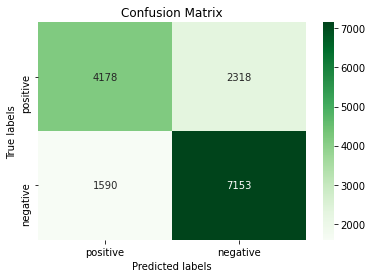

array([[4178, 2318],
       [1590, 7153]])

In [12]:
biased_dataset = generate_biased_dataset(dataset, women_yes_event_subsample_rate = 0.6)

biased_rf, X_cols,X_train, X_test, y_train, y_test = train_model(biased_dataset)
plot_confusion_matrix(y_test, biased_rf.predict(X_test[X_cols]))

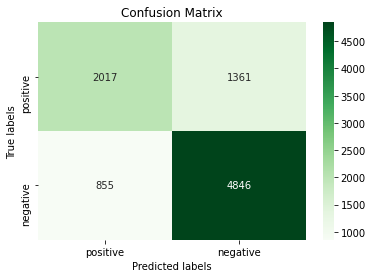

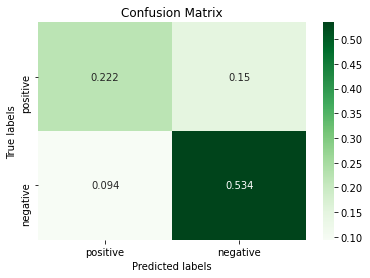

array([[0.222, 0.15 ],
       [0.094, 0.534]])

In [13]:
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)

cm_female = plot_confusion_matrix(
    y_test[women_test_idx], 
    biased_rf.predict(X_test[X_cols][women_test_idx]))

plot_confusion_matrix(
    y_test[women_test_idx], 
    biased_rf.predict(X_test[X_cols][women_test_idx]),return_percentage=True)

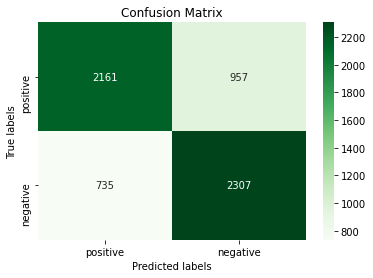

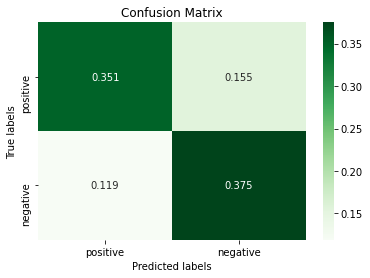

array([[0.351, 0.155],
       [0.119, 0.375]])

In [14]:
cm_male = plot_confusion_matrix(
    y_test[men_test_idx], 
    biased_rf.predict(X_test[X_cols][men_test_idx]),)
plot_confusion_matrix(
    y_test[men_test_idx], 
    biased_rf.predict(X_test[X_cols][men_test_idx]),return_percentage=True)

### Place your disparate impact and equal opportunity difference measurements here¶

In [15]:
# compute equal opportunity difference
tpr_female = calc_metric(cm_female, metric="tpr")
tpr_male = calc_metric(cm_male, metric="tpr")
eodiff = tpr_female-tpr_male
print(f"Equal opportunity difference:\n\tRecall (female):\t{tpr_female}")
print(f"\tRecall (male):\t\t{tpr_male}")
print(f"\tEqual opp. diff.:\t{eodiff}")

# compute disparate impact
pos_rate_female = calc_metric(cm_female, metric="pos_rate")
pos_rate_male = calc_metric(cm_male, metric="pos_rate")
disp_impact = pos_rate_female/pos_rate_male
print(f"Disparate impact:\n\tPositive rate (female):\t{pos_rate_female}")
print(f"\tPositive rate (male):\t{pos_rate_male}")
print(f"\tEqual opp. diff.:\t{disp_impact}")

Equal opportunity difference:
	Recall (female):	0.5970988750740083
	Recall (male):		0.6930724823604875
	Equal opp. diff.:	-0.09597360728647919
Disparate impact:
	Positive rate (female):	0.3163343980614605
	Positive rate (male):	0.4701298701298701
	Equal opp. diff.:	0.6728659848268636


In [18]:
# convert test df to aif360 format
X_test_df = X_test
aif360_gt_df = pandas_to_aif360(X_test_df.join(y_test))

# predict y_test and convert to aif360 
yhat_test = X_test
yhat_test["cardio"] = original_rf.predict(X_test)
aif360_pred_df = pandas_to_aif360(yhat_test)

In [19]:
# set gender codes
female_code = 1
male_code = 2
metric = aif360.metrics.BinaryLabelDatasetMetric(aif360_gt_df,
                                        unprivileged_groups=[{'gender':1}],
                                        privileged_groups=[{'gender':2}])
print(f"Fairness metrics test dataset:\n\tBase rate (female):\t{metric.base_rate(privileged=True).round(3)}")
print(f"\tBase rate (male):\t{metric.base_rate(privileged=False).round(3)}")
print(f"\n\tDisparate impact:\t{metric.disparate_impact().round(3)}")
print(f"\n\tMean difference:\t{metric.mean_difference().round(3)}")

Fairness metrics test dataset:
	Base rate (female):	0.506
	Base rate (male):	0.372

	Disparate impact:	0.735

	Mean difference:	-0.134


In [21]:
# metrics on classified data
# predicted_labels(original_rf.predict(X_test[X_cols]))
model_metrics = aif360.metrics.ClassificationMetric(aif360_gt_df, aif360_pred_df,
                                    unprivileged_groups=[{'gender':1}],
                                    privileged_groups=[{'gender':2}])

print(f"Fairness metrics classifier:\n\tBase rate (female):\t{model_metrics.base_rate(privileged=True).round(3)}")
print(f"\tBase rate (male):\t{model_metrics.base_rate(privileged=False).round(3)}")
print(f"\n\tDisparate impact:\t{model_metrics.disparate_impact().round(3)}")
print(f"\n\tTheil index:\t\t{model_metrics.theil_index().round(3)}")
print(f"\n\tEqual opp diff:\t\t{model_metrics.true_positive_rate_difference().round(3)}")
print(f"\n\tConsistency:\t\t{model_metrics.consistency()[0].round(3)}")


Fairness metrics classifier:
	Base rate (female):	0.506
	Base rate (male):	0.372

	Disparate impact:	0.765

	Theil index:		0.046

	Equal opp diff:		0.005

	Consistency:		0.631


## 4. Use SHAP to interpret the biased model's predictions and demonstrate bias.

* It is relatively simple to show that the model is considering gender by creating a SHAP summary plot, as we learnt in milestone 1.
* If we were looking at this model for the first time, without prior knowledge that it had gender bias, seeing gender as a very important feature would be a red flag.
* It is not possible to determine from the SHAP plot if the gender feature is given high importance because of genuine physiological differences, or if unwanted algorithmic bias is present.

Generate a SHAP summary plot explaining the biased model. You learned this process in Milestone 1, but there is one difference here, because you are interpreting a classifier instead of a regressor.

Regressor: `shap.summary_plot(shap_values, X_test[:50])`

Classifier: `shap.summary_plot(shap_values[1], X_test[:50])`

## Optional Exercise

An interesting question: If the SHAP value is indicating that the 'gender' variable has some importance, and we don't want it to be a source of bias, could we simply remove it rather than going through a time-consuming debiasing process?

Unfortunately, it is usually not so simple. In this instance, like many others, the model will be able to approximate gender using other variables. Removing the variable also can reduce the accuracy of the model.

As an optional exercise, if you are curious, you can train a model without the 'gender' variable and confirm that removing the gender variable does not resolve all the algorithmic bias issues. You can pass in **exclude_gender=True** to the train_model helper function. Repeat the previous process of generating confusion matrices and manually calculating disparate impact and equal opportunity difference. Though there is less bias, it is not removed.

# Debiasing our model with AIF360

We have now manually observed bias which might be unwanted. We should nail down exactly what these biases are. There are at least two obvious biases in the model we built:
 1. Due directly to our tampering with the dataset, the model predicts more positive cases for men than women. **The relevant bias metric here is disparate impact.**
 2. The model's errors are distributed unevenly across genders: women have a lower true positive rater than men. **The relevant bias metric here is equal opportunity difference.**

The question remains which of these biases are unwanted algorithmic biases, and how we could mitigate them 

1. In this milestone, we artifically caused disparate impact **(1)**. However, disparities between men and women can be due to general physiological differences (for example, breast cancer is [70-100 times less common in men than in women](https://www.cancer.org/cancer/breast-cancer-in-men/about/key-statistics.html). With more knowledge about the experimental setup, a subject matter expert in cardiovascular disease would be able to give a qualified answer about the source of the bias and whether or not it's unwanted. For learning purposes, we will assume that this bias is unwanted and attempt to remove it.

2. The uneven distribution of errors **(2)** is more straightforward. The model errors are unfairly distributed in such a way that borderline cases in women are more likely to be judged as negative than borderline cases in men. If we can resolve this without a substantial drop in overall accuracy, that would usually be the correct choice.

For learning purposes, we will attempt to mitigate both types of bias. 

## Debiasing steps

1. Load train and test datasets into AIF360.
2. Using ClassificationMetric, measure key bias metrics (accuracy, disparate impact, equal opportunity difference) in the biased model's predictions. 
3. Use each of the following debiasing methods:
   * Pre-processing debiasing methods
      * Reweighing

      * Disparate Impact Remover

   * Post-processing debiasing methods

      * Calibration
4. Decide on a preferred debiasing approach
5. Select optimal thresholds and understand tradeoffs

Since this workflow is quite complicated, most code is already provided. If you feel confident, you do not need to use the provided code. 

The parts of the workflow without provided code deserve special note. Based on the Reweighing example, you should be able to mitigate bias on your own using Disparate Impact remover. Using your knowledge of bias and performance metrics, you should be able to decide on a preferred debiasing approach and select an optimal threshold.

### Understanding AIF360 Datasets and ClassificationMetrics

For our purposes, AIF360 BinaryLabelDatasets have four key components:


| Component  | Code  | Description  | 
| --- | --- | ---
| Features | BinaryLabelDataset.features  |  features (usually inputs to a model).
| Scores  | BinaryLabelDataset.scores |  probability of a positive event.
| Labels  | BinaryLabelDataset.labels  | record of a positive event. Can be 1 or 0. 
| Weights  | BinaryLabelDataset.instance_weights  | when using Reweighing, instance weights will be placed here.

When we run an inference over the dataset, we replace both the scores and the labels with the model's prediction over the dataset's features.

When we measure bias metrics with ClassificationMetric, we generally need to pass in two BinaryLabelDataset objects. The first object will be the original dataset, the second will be the dataset which has had some inference run on it.

In [24]:
aif360_biased_dataset_train = pandas_to_aif360(pd.concat([X_train, y_train], axis=1)) #this is a helper function, you could instead use the below
# aif360_biased_dataset = aif360.datasets.BinaryLabelDataset(1,0,df=pd.concat([X_train, y_train], axis=1),label_names=['cardio'],protected_attribute_names=['gender'])
aif360_biased_dataset_test = pandas_to_aif360(pd.concat([X_test.drop(["cardio"], axis=1), y_test], axis=1))
results = {}

### Measure key bias metrics using the original model to predict on the test set

 - Here we want to measure our key bias metrics (equal opportunity difference and disparate impact), as well as measure accuracy and precision in general, with AIF-360.
 - This serves both to confirm the manual measurements you already made and to serve as a benchmark for each debiasing method we will try.

In [25]:
dataset_pred = aif360_biased_dataset_test.copy()
dataset_pred.labels = biased_rf.predict(aif360_biased_dataset_test.features)
dataset_pred.scores = biased_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]

unprivileged_groups = [{'gender':1.0}] #women
privileged_groups = [{'gender':2.0}] #men

metric = ClassificationMetric(
        aif360_biased_dataset_test, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['original_model'] = {'accuracy':metric.accuracy(),
                               'precision':metric.precision(),
                               'eq_diff': metric.equal_opportunity_difference(),
'disparate_impact':metric.disparate_impact()}

## Preprocessing the data using Reweighing

Reweighing works by assigning weights to each row in the train dataset, such that the proportion of (group, outcome) is equal. A model can be then trained on the reweighed train dataset and tested on the test dataset without any reweighing. The steps are as follows:

 - Initialize reweighing object
 - Using fit_transform, create a reweighed train dataset from aif360_biased_dataset_train
 - Create a new model (eg RF) and train it on the reweighed train dataset
 - Use the new model to predict on the test dataset
 - Using ClassificationMetric, evalutae performance on the test dataset

In [26]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) #initialize reweighing object
reweighed_dataset = RW.fit_transform(aif360_biased_dataset_train) #create reweighed train dataset

#train new model on reweighed dataset
reweighed_rf = RandomForestClassifier(random_state=42) 
reweighed_rf.fit(reweighed_dataset.features, reweighed_dataset.labels.ravel(), sample_weight=reweighed_dataset.instance_weights)

#infer on the test dataset using new model
reweighing_test = aif360_biased_dataset_test.copy()
reweighing_test.scores = reweighed_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]
reweighing_test.labels = reweighed_rf.predict(aif360_biased_dataset_test.features) 

metric = ClassificationMetric(
        aif360_biased_dataset_test, reweighing_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['reweigher'] = {'accuracy':metric.accuracy(),
                        'precision':metric.precision(),
                        'eq_diff': metric.equal_opportunity_difference(),
                        'disparate_impact':metric.disparate_impact()} 

## Preprocessing the data using Disparate Impact Remover

Disparate Impact Remover works by dividing the training set according to protected class and ensuring that the features in all divisions have similar distributions. A model can be then trained on the altered train dataset and tested on the unchanged test dataset. The steps are as follows:

 - Initialize Disparate Impact Remover object (you need to pass in the 'sensitive_attribute' and repair level)
 - Using fit_transform, create an altered train dataset from aif360_biased_dataset_train
 - Create a new model (eg RF) and train it on the reweighed train dataset
 - Use the new model to predict on the test dataset
 - Using ClassificationMetric, evalutae performance on the test dataset
 
This pipeline is very similar to the Reweighing pipeline. Use the Reweighing pipeline code as a guide to implement this part.

<!-- ## In-processing debiasing using Prejudice Remover

Prejudice Remover trains a model with a regularization term to penalize discrimination along protected-class lines. For this method, the original model is not necessary. The steps are as follows:

 - Initialize PrejudiceRemover object
 - Train the PrejudiceRemover on the train dataset
 - Use the PrejudiceRemover to predict on the test dataset
 - Using ClassificationMetric, evaluatee performance on the test dataset
 -->

## Post-processing debiasing using Calibrated Equal Odds Postprocessing

Calibrated Equal Odds Postprocessing adds an additional objective for regions of the model's prediction which carry high differences in odds between the protected and unprotected class members. The steps are as fllows:

 - Use the original model to predict on both the train and test sets
 - Initialize the CalibratedEqOddsPostprocessing object 
 - Train the postprocessor on the model's predictions for the train dataset
 - Run the postprocessor on the model's predictions for the test dataset
 - Using ClassificationMetric, evaluate the performance of the postprocessor

In [27]:
postprocessor = CalibratedEqOddsPostprocessing(unprivileged_groups, privileged_groups)
dataset_pred_train = aif360_biased_dataset_train.copy()
dataset_pred_test = aif360_biased_dataset_test.copy()
dataset_pred_train.labels = biased_rf.predict(aif360_biased_dataset_train.features)
dataset_pred_train.scores = biased_rf.predict_proba(aif360_biased_dataset_train.features)[:,1]
dataset_pred_test.labels = biased_rf.predict(aif360_biased_dataset_test.features)
dataset_pred_test.scores = biased_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]

postprocessor.fit(aif360_biased_dataset_train, dataset_pred_train)

postprocessed = postprocessor.predict(dataset_pred_test)

metric = ClassificationMetric(
        aif360_biased_dataset_test, postprocessed,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['post-calibration'] = {'accuracy':metric.accuracy(),
                               'precision':metric.precision(),
                                'eq_diff': metric.equal_opportunity_difference(),
                                'disparate_impact':metric.disparate_impact()}


## Summarize your results
Review the accuracy, precision, equal opportunity difference, and disparate impact for the original model and each debiasing method. Does debiasing make a difference? Is there a large tradeoff between accuracy/precision and the debiasing process? 

In [28]:
pd.DataFrame(results).T

,accuracy,precision,eq_diff,disparate_impact
original_model,0.743553,0.724341,-0.095974,0.672866
reweigher,0.741912,0.723064,-0.090127,0.686807
post-calibration,0.740206,0.717918,-0.114180,0.657150


### 6. Threshold Selection

The output of both Reweighing and Disparate Impact Removers is a new classifier object. These classifiers can be fine-tuned further by selecting a threshold.

The default threshold for scikit-learn classifiers is 0.5 . The classifier's binary output represents an expected probability either below or above/equal this theshold. We can manipulate the threshold if we see that a different threshold shows improved results.

When debiasing, threshold selection is especially important, because it gives data scientists a sense of how much model performance could be sacrificed to reach a certain bias measure (eg >0.8 Disparate Impact). If the sacrifice to model performance is low, an alternate threshold with better bias metrics could be chosen. 

Below you are provided some sample code which evaluates each percentage threshold from 0% to 100% for the original biased model and Reweighing model. You are asked to do the following:

 - Run the code to evaluate each percentage threshold
 - Add additional code to evaluate the percentage thresholds for the Reweighing model
 - Observe the shifts in accuracy, precision, disparate impact and average odds difference across each threshold
 - Is it possible to say which model, provides the best performance and at which threshold? Would you recommend a non-default threshold for your preferred model? Refer to the resource on impossibility for an explanation of why one threshold will not maximize all metrics.

In [29]:
reports = []
pd.set_option('display.max_rows', 1000)
for thresh in np.linspace(0,1,101):
    #apply new threshold
    dataset_pred.labels = dataset_pred.scores>=thresh 
    reweighing_test.labels = reweighing_test.scores>=thresh
    
    #get bias and acccuracy metrics
    metric_original_rf = ClassificationMetric(
        aif360_biased_dataset_test, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    metric_reweighed_rf = ClassificationMetric(
        aif360_biased_dataset_test, reweighing_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

    #record metrics
    reports.append((thresh, 
          metric_original_rf.accuracy(), 
          metric_original_rf.average_odds_difference(),
          metric_original_rf.disparate_impact(),
          metric_reweighed_rf.accuracy(), 
          metric_reweighed_rf.average_odds_difference(),
          metric_reweighed_rf.disparate_impact()))

report_df = pd.DataFrame(reports)
report_df.columns = ['threshhold','accuracy_original',
                     'average_odds_difference_original',
                     'disparate_impact_original',
                     'accuracy_reweighed',
                     'average_odds_difference_reweighed',
                     'disparate_impact_reweighed']
display(report_df.set_index('threshhold'))

invalid value encountered in double_scalars


,accuracy_original,average_odds_difference_original,disparate_impact_original,accuracy_reweighed,average_odds_difference_reweighed,disparate_impact_reweighed
threshhold,,,,,,
0.00,0.426275,0.000000,1.000000,0.426275,0.000000,1.000000
0.01,0.428440,-0.003130,0.996145,0.429293,-0.003530,0.995477
0.02,0.431918,-0.008632,0.989527,0.433493,-0.009094,0.988576
0.03,0.437824,-0.015330,0.981082,0.439465,-0.015432,0.980555
0.04,0.445961,-0.025449,0.968495,0.446617,-0.023203,0.970599
0.05,0.455345,-0.034096,0.956951,0.455476,-0.030807,0.960340
0.06,0.464794,-0.041555,0.946578,0.464926,-0.037347,0.950914
0.07,0.474834,-0.050454,0.934410,0.473850,-0.043009,0.942446
0.08,0.485006,-0.059789,0.921678,0.484284,-0.050736,0.931121


## Complete the deliverable

This notebook, complete with your reflections, is your deliverable.